# Hedging Behaviour in Multi-Armed Bandits

In this notebook, we're going to explore what's called "hedging" behaviour. 
Hedging occurs when the optimal recommendation policy does not merely focus on a _single_ best action (with possibly high variance), but rather allocates probability mass over various competing actions as to minimise the risk of getting a low reward.

This can be attained via two mechanisms that we will adopt here:
1. A logarithmic utility function that reflects diminishing returns on rewards for the same action
2. Uncertainty-aware decision-making that reflects the uncertainty on the reward for different actions


For simplicity and illustrative purposes, we will focus on a multi-armed bandit problem with two actions (but the observations extend to the contextual case with larger action spaces).

Assume we have $n$ opportunities to take an action — or show a recommendation to a user.
Our goal is to decide how often we should perform action 1 ($0 \leq I_{1} \leq n$), and how often we should perform action 2 ($I_{2} = n - I_{1}$), as to maximise utility.

We will assume that rewards (clicks) are drawn from a beta-binomial distribution.
The parameters for an action-specific beta-binomial ($\alpha_{1}, \beta_{1}$ for action $a_{1}$) can be interpreted as the number of observed clicks and the number of observed non-clicks for that action respectively.
We add pseudo-counts of 1 to said parameters, which corresponds to having a uniform conjugate prior of 50\% on the probability of reward.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
figsize = (8,4)
figsize_dbl = (16,4)
fontsize = 16

import numpy as np
from scipy.stats import betabinom

n = 100
# P(C = 1 | A = 1)
alpha1, beta1 = 400000, 600000 # Centered at 40% with low uncertainty
# P(C = 1 | A = 2)
alpha2, beta2 = 2, 2   # Centered at 50% with high uncertainty

In [2]:
def probable_clicks(I1, n=n, alpha1=alpha1, beta1=beta1, alpha2=alpha2, beta2=beta2):    
    # Compute probability mass function for P(C = 1 | A = 1)
    x1 = np.arange(I1+1)
    p1 = betabinom.pmf(x1, I1, alpha1, beta1)

    # Compute probability mass function for P(C = 1 | A = 2) 
    I2 = n - I1
    x2 = np.arange(I2+1)
    p2 = betabinom.pmf(x2, I2, alpha2, beta2)
    
    # Compute probability mass function for P(C | A)
    # The sum of two independent random variables is distributed
    # according to the convolution of their individual distributions.
    p = np.convolve(p1,p2)
    x = np.linspace(0, n, n+1)

    return x, p

We can now visualise how the probability of observing $0 \leq c \leq n$ clicks is distributed:

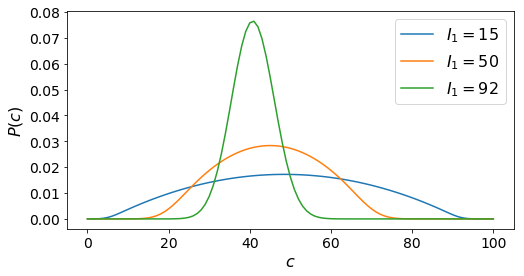

In [3]:
frac = [.15, .5, .92]
I1_list = [int(f*n) for f in frac]

_,_ = plt.subplots(1,1,figsize=figsize)
for I1 in I1_list:
    x, p = probable_clicks(I1)
    plt.plot(x,p, label=r'$I_{1}='+f'{I1}$')
    
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.xlabel('$c$', fontsize=fontsize)
plt.ylabel('$P(c)$', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

When we pull arm 1 only 15% of the time, we see large uncertainty over the expected number of clicks.
Conversely, when pulling arm 1 for 92\% of the time, we observe a much more concentrated distribution, reflecting the reduced uncertainty for action 1 in contrast with action 2.

We can see that the mode of the reward distribution is higher for action 2, and as such we can expect more clicks from action 2 than we can expect from action 1.
Many traditional approaches to recommendation (or machine learning in general) would stop here and assume that we should trust the data and go with action 2.

We know, however, that this leaves us vulnerable to optimiser's curse.
Furthermore, we are not tied to the assumption that the expected number of clicks is the goal of the system.

We can formulate the expected _utility_ however we see fit.
Let's say we want to maximise the number of observed clicks on the recommendations that we show, but with diminishing returns.
That is, going from 1 to 2 clicks should weigh in more than going from 1000 to 1001 clicks.

Traditionally, such behaviour is modelled through a logarithmic transformation.

We visualise the utility landscape over varying values of $I_{1}$ for both types of utility functions.

In [4]:
def linear_utility(I1, alpha1=alpha1, beta1=beta1, alpha2=alpha2, beta2=beta2):
    # Compute the probability mass function for P(C|A)
    x, p = probable_clicks(I1, alpha1=alpha1, beta1=beta1, alpha2=alpha2, beta2=beta2)
    # Compute the expected value of the utility function
    return sum(x*p)

def logarithmic_utility(I1, alpha1=alpha1, beta1=beta1, alpha2=alpha2, beta2=beta2):
    # Compute the probability mass function for P(C|A)
    x, p = probable_clicks(I1, alpha1=alpha1, beta1=beta1, alpha2=alpha2, beta2=beta2)
    # Compute the expected value of the utility function
    return sum(np.log(x+1)*p)

Optimal I1 under linear utility:	0
Optimal I1 under logarithmic utility:	21


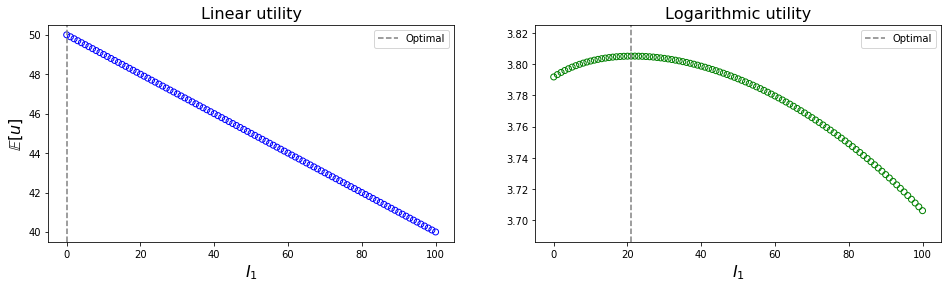

In [5]:
_, axes = plt.subplots(1,2,figsize=figsize_dbl)

x = np.arange(n+1)

y = np.asarray([linear_utility(I1) for I1 in x])
print(f'Optimal I1 under linear utility:\t{np.argmax(y)}')
axes[0].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[0].scatter(x,y,marker='o',facecolors='none',edgecolors='b')
axes[0].set_title('Linear utility', fontsize=fontsize)
axes[0].legend()


y = np.asarray([logarithmic_utility(I1) for I1 in x])
print(f'Optimal I1 under logarithmic utility:\t{np.argmax(y)}')
axes[1].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[1].scatter(x,y,marker='o',facecolors='none',edgecolors='g')
axes[1].set_title('Logarithmic utility',fontsize=fontsize)
axes[1].legend()

axes[0].set_xlabel('$I_{1}$', fontsize=fontsize)
axes[1].set_xlabel('$I_{1}$', fontsize=fontsize)
axes[0].set_ylabel('$\mathbb{E}[u]$', fontsize=fontsize)

plt.show()

Our intuition works as expected: when we define utility to be linear, we effectively only care about the expected number of clicks and pulling arm 2 is always the optimal policy.

We can use a transformation on the utility function to makeus risk-averse, and prefer a policy that allocates probability mass to both competing actions.

We can compare this with another trick often used in the literature: Sample Variance Penalisation (SVP).
SVP makes the bias-variance trade-off explicit, by optimising a lower-bound on the expected utility.

## Connections (and Differences) with Variance Penalisation

Until now, we used the posterior means of the reward distributions to base our notion of utility on.
Let's visualise these posterior distributions, so we can investigate the uncertainties.

What sample-variance-penalisation actually does, is promote lower-confidence-bound decision-making.
The SVP strength parameter $\lambda$ is a hyper-parameter that needs to be tuned, as the optimal value of $I_{1}$ entirely depends on the choice of the confidence band width.

To keep things simple and focused -- we will compute the analytical variance of the posterior predictive for the distribution over the number of clicks.

In [6]:
C1, NC1 = 3, 5
alpha1, beta1 = C1 + 1, NC1 + 1

C2, NC2 = 1, 1
alpha2, beta2 = C2 + 1, NC2 + 1

alpha1, beta1, alpha2, beta2

(4, 6, 2, 2)

Optimal I1 under true variance:		68


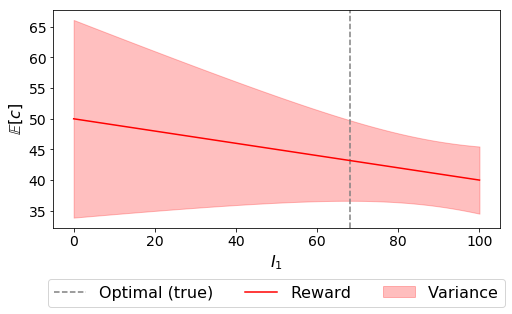

In [7]:
from scipy.stats import beta

_,_ = plt.subplots(1,1,figsize=figsize)

lambda_svp = 1

x = np.arange(n+1)
y_mean = []
y_analytical_var = []

for I1 in x:
    I2 = n - I1
    # Compute mean
    mean = betabinom.mean(I1,alpha1,beta1) + betabinom.mean(I2,alpha2,beta2)
    y_mean.append(mean)

    # Compute analytical variance
    analytical_var = np.sqrt(betabinom.var(I1,alpha1,beta1) / (alpha1+beta1-2) +  betabinom.var(I2,alpha2,beta2) / (alpha2+beta2-2))        
    y_analytical_var.append(analytical_var)
        
y_mean = np.array(y_mean)
y_analytical_var = np.array(y_analytical_var)

plt.axvline(np.argmax(y_mean - lambda_svp * y_analytical_var),linestyle='--',color='gray',label='Optimal (true)')
print(f'Optimal I1 under true variance:\t\t{np.argmax(y_mean - lambda_svp * y_analytical_var)}')
plt.plot(x, y_mean, label = 'Reward', color ='r')
plt.fill_between(x,
                 y_mean - lambda_svp * y_analytical_var,
                 y_mean + lambda_svp * y_analytical_var,
                 alpha = .25,
                 color = 'r',
                 label='Variance')

plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.xlabel('$I_{1}$', fontsize=fontsize)
plt.ylabel('$\mathbb{E}[c]$', fontsize=fontsize)
plt.legend(fontsize=fontsize,ncol=4,loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.show()

In [8]:
def SVP_reward(I1, n, alpha1, beta1, alpha2, beta2, lambda_svp = 1.96):
    I2 = n - I1
    
    # Analytical variance:
    return betabinom.mean(I1,alpha1,beta1) + betabinom.mean(I2,alpha2,beta2) \
    - lambda_svp * np.sqrt(betabinom.var(I1,alpha1,beta1)/(alpha1+beta1-2) +  betabinom.var(I2,alpha2,beta2)/(alpha2+beta2-2))

## Comparing logarithmic utility with SVP for varying reward distributions

#### Low uncertainty on action 1, low uncertainty on action 2

When there is low uncertainty everywhere, we can just trust the data.
In this case, as action 2 has the highest expected reward, the optimal policy takes action 2 all the time (i.e. $I_{1} = 0$).

The logarithmic utility function will not stimulate hedging when the difference between the expected clicks of the two arms is too large, and SVP agrees with the logarithmic utility function.

Optimal I1 under logarithmic utility:		   0
Optimal I1 under sample variance penalisation:	   0


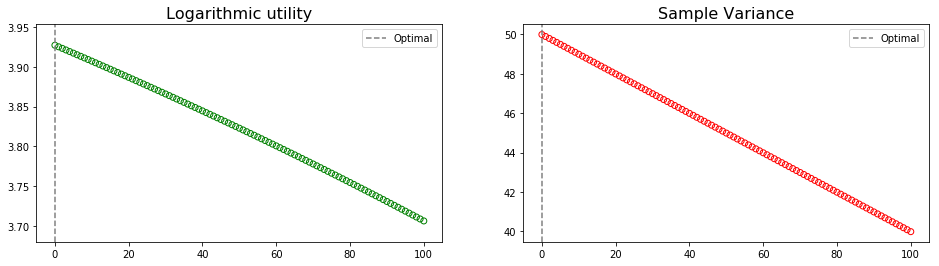

In [9]:
_, axes = plt.subplots(1,2,figsize=figsize_dbl)

x = np.arange(n+1)

alpha1, beta1 = 400000, 600000
alpha2, beta2 = 500000, 500000

y = np.asarray([logarithmic_utility(I1, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under logarithmic utility:\t\t{np.argmax(y):4d}')
axes[0].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[0].scatter(x,y,marker='o',facecolors='none',edgecolors='g')
axes[0].set_title('Logarithmic utility',fontsize=fontsize)
axes[0].legend()

y = np.asarray([SVP_reward(I1, n, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under sample variance penalisation:\t{np.argmax(y):4d}')
axes[1].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[1].scatter(x,y,marker='o',facecolors='none',edgecolors='r')
axes[1].set_title('Sample Variance',fontsize=fontsize)
axes[1].legend()

plt.show()

#### Low uncertainty on action 1, high uncertainty on action 2
When we have low uncertainty on the first action, but high uncertainty on the 2nd action, we observe hedging behaviour that tries to avoid risk.
We are essentially being pessimistic in this setting.

Optimal I1 under logarithmic utility:		  21
Optimal I1 under sample variance penalisation:	 100


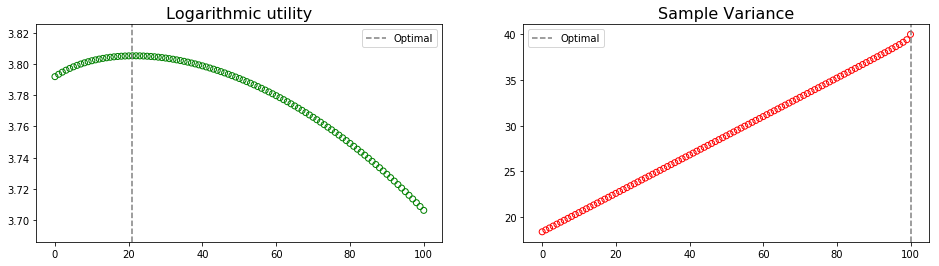

In [10]:
_, axes = plt.subplots(1,2,figsize=figsize_dbl)

x = np.arange(n+1)

alpha1, beta1 = 400000, 600000
alpha2, beta2 = 2, 2

y = np.asarray([logarithmic_utility(I1, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under logarithmic utility:\t\t{np.argmax(y):4d}')
axes[0].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[0].scatter(x,y,marker='o',facecolors='none',edgecolors='g')
axes[0].set_title('Logarithmic utility',fontsize=fontsize)
axes[0].legend()

y = np.asarray([SVP_reward(I1, n, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under sample variance penalisation:\t{np.argmax(y):4d}')
axes[1].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[1].scatter(x,y,marker='o',facecolors='none',edgecolors='r')
axes[1].set_title('Sample Variance',fontsize=fontsize)
axes[1].legend()

plt.show()

#### High uncertainty on action 1, low uncertainty on action 2

Optimal I1 under logarithmic utility:		   0
Optimal I1 under sample variance penalisation:	   0


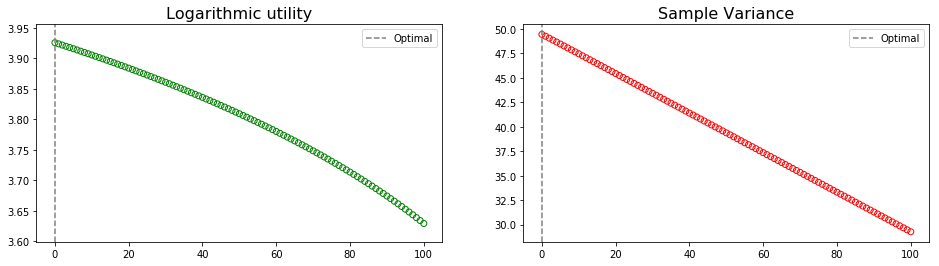

In [11]:
_, axes = plt.subplots(1,2,figsize=figsize_dbl)

x = np.arange(n+1)

alpha1, beta1 = 4, 6
alpha2, beta2 = 200, 200

y = np.asarray([logarithmic_utility(I1, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under logarithmic utility:\t\t{np.argmax(y):4d}')
axes[0].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[0].scatter(x,y,marker='o',facecolors='none',edgecolors='g')
axes[0].set_title('Logarithmic utility',fontsize=fontsize)
axes[0].legend()

y = np.asarray([SVP_reward(I1, n, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under sample variance penalisation:\t{np.argmax(y):4d}')
axes[1].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[1].scatter(x,y,marker='o',facecolors='none',edgecolors='r')
axes[1].set_title('Sample Variance',fontsize=fontsize)
axes[1].legend()

plt.show()

#### High uncertainty on action 1, high uncertainty on action 2

Optimal I1 under logarithmic utility:		  16
Optimal I1 under sample variance penalisation:	  81


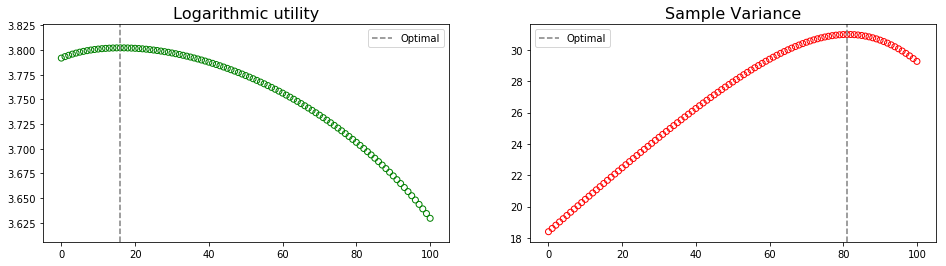

In [12]:
_, axes = plt.subplots(1,2,figsize=figsize_dbl)

x = np.arange(n+1)

alpha1, beta1 = 4, 6
alpha2, beta2 = 2, 2

y = np.asarray([logarithmic_utility(I1, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under logarithmic utility:\t\t{np.argmax(y):4d}')
axes[0].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[0].scatter(x,y,marker='o',facecolors='none',edgecolors='g')
axes[0].set_title('Logarithmic utility',fontsize=fontsize)
axes[0].legend()

y = np.asarray([SVP_reward(I1, n, alpha1, beta1, alpha2, beta2) for I1 in x])
print(f'Optimal I1 under sample variance penalisation:\t{np.argmax(y):4d}')
axes[1].axvline(np.argmax(y),linestyle='--',color='gray',label='Optimal')
axes[1].scatter(x,y,marker='o',facecolors='none',edgecolors='r')
axes[1].set_title('Sample Variance',fontsize=fontsize)
axes[1].legend()

plt.show()